In [1]:
import fastf1
import pandas as pd
import os
import numpy as np
import requests
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Use absolute path to avoid confusion
cache_dir = "f1_cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)

def calculate_actual_clean_air_pace(session):
    """Calculate clean air race pace from actual race data"""
    try:
        laps = session.laps.copy()
        laps['LapTime_seconds'] = laps['LapTime'].dt.total_seconds()
        laps = laps.dropna(subset=['LapTime_seconds'])
        
        # Remove outliers and problematic laps
        fastest_lap = laps['LapTime_seconds'].min()
        laps = laps[laps['LapTime_seconds'] <= fastest_lap * 1.15]
        
        # Remove early and late race laps
        max_lap = laps['LapNumber'].max()
        laps = laps[(laps['LapNumber'] >= 4) & (laps['LapNumber'] <= max_lap - 2)]
        
        clean_air_pace = {}
        for driver in laps['Driver'].unique():
            driver_laps = laps[laps['Driver'] == driver]['LapTime_seconds']
            if len(driver_laps) >= 5:
                # Use 25th to 50th percentile for consistent pace
                q25 = driver_laps.quantile(0.25)
                q50 = driver_laps.quantile(0.50)
                clean_laps = driver_laps[(driver_laps >= q25) & (driver_laps <= q50)]
                if len(clean_laps) > 0:
                    clean_air_pace[driver] = clean_laps.mean()
                else:
                    clean_air_pace[driver] = driver_laps.quantile(0.4)
        
        return clean_air_pace
    except Exception as e:
        print(f"Warning: Could not calculate clean air pace - {e}")
        return None

def advanced_feature_engineering(merged_data):
    """Create advanced features for better predictions"""
    
    # 1. Ranking features
    merged_data['QualifyingTimeRank'] = merged_data['QualifyingTime (s)'].rank()
    merged_data['CleanAirPaceRank'] = merged_data['CleanAirRacePace (s)'].rank()
    
    # 2. Pace ratio features
    merged_data['QualifyingPaceRatio'] = (
        merged_data['QualifyingTime (s)'] / merged_data['CleanAirRacePace (s)']
    )
    
    # 3. Team-relative performance
    team_avg_quali = merged_data.groupby('Team')['QualifyingTime (s)'].mean()
    merged_data['TeamQualifyingAdvantage'] = merged_data.apply(
        lambda row: team_avg_quali[row['Team']] - row['QualifyingTime (s)'], axis=1
    )
    
    # 4. Grid position factors
    merged_data['GridPositionAdvantage'] = 1 / (merged_data['QualifyingPosition'] + 1)
    merged_data['StartingPositionPressure'] = np.log(merged_data['QualifyingPosition'] + 1)
    
    # 5. Weather impact
    merged_data['RainTemperatureInteraction'] = merged_data['RainProbability'] * (20 - merged_data['Temperature'])
    
    # 6. Team strength vs driver performance
    merged_data['DriverTeamSynergy'] = (
        merged_data['TeamPerformanceScore'] * merged_data['GridPositionAdvantage']
    )
    
    # 7. Expected race performance
    merged_data['ExpectedRaceGain'] = -merged_data['AveragePositionChange']
    merged_data['QualifyingToRacePaceGap'] = (
        merged_data['CleanAirRacePace (s)'] - merged_data['QualifyingTime (s)']
    )
    
    # 8. Rookie/Experience factor
    rookie_drivers = ['ANT', 'HAD', 'BOR']
    merged_data['ExperienceFactor'] = merged_data['Driver'].apply(
        lambda x: 0.85 if x in rookie_drivers else 1.0
    )
    
    # 9. Team competitiveness tiers
    top_teams = ['McLaren', 'Ferrari', 'Red Bull']
    mid_teams = ['Mercedes', 'Aston Martin']
    merged_data['TeamTier'] = merged_data['Team'].apply(
        lambda x: 1 if x in top_teams else (2 if x in mid_teams else 3)
    )
    
    return merged_data


In [3]:
# Load 2024 British GP session data
print("🏁 Loading 2024 British GP data...")
session_2024 = fastf1.get_session(2024, 12, "R")
session_2024.load()

# Calculate actual clean air pace
print("📊 Calculating clean air race pace...")
calculated_pace = calculate_actual_clean_air_pace(session_2024)

if calculated_pace:
    clean_air_race_pace_silverstone = calculated_pace
    print("✅ Using calculated clean air pace from 2024 data")
    for driver, pace in sorted(calculated_pace.items(), key=lambda x: x[1])[:5]:
        print(f"   {driver}: {pace:.3f}s")
else:
    # Enhanced estimates based on 2024 performance and driver moves
    clean_air_race_pace_silverstone = {
        "VER": 87.2, "PIA": 86.8, "NOR": 86.5, "RUS": 87.4, "HAM": 87.8,
        "LEC": 87.1, "ALO": 88.0, "GAS": 88.2, "SAI": 87.6, "ANT": 88.5,
        "TSU": 88.1, "HAD": 89.0, "ALB": 88.3, "OCO": 88.4, "LAW": 88.7,
        "BOR": 89.5, "STR": 88.9, "BEA": 88.6, "HUL": 87.9, "COL": 89.2
    }
    print("⚠️  Using enhanced estimated clean air pace")

# Process lap data
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)

for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean", 
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


🏁 Loading 2024 British GP data...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']


📊 Calculating clean air race pace...
✅ Using calculated clean air pace from 2024 data
   PIA: 91.191s
   HAM: 91.194s
   LEC: 91.327s
   VER: 91.386s
   NOR: 91.413s


In [4]:
# British GP 2025 qualifying data (actual results)
qualifying_2025_silverstone = pd.DataFrame({
    "Driver": ["VER", "PIA", "NOR", "RUS", "HAM", "LEC", "ALO", "GAS", 
               "SAI", "ANT", "TSU", "HAD", "ALB", "OCO", "LAW", "BOR", 
               "STR", "BEA", "HUL", "COL"],
    "QualifyingTime (s)": [  
        84.892, 84.995, 85.010, 85.029, 85.095, 85.121, 85.621, 85.785,
        85.746, 85.374, 85.826, 85.864, 85.889, 85.950, 86.440, 86.446,
        86.504, 85.471, 86.574, 87.060
    ],
    "QualifyingPosition": list(range(1, 21))
})

qualifying_2025_silverstone["CleanAirRacePace (s)"] = qualifying_2025_silverstone["Driver"].map(clean_air_race_pace_silverstone)

# Enhanced team performance
team_points_updated = {
    "McLaren": 666,     # Dominant development
    "Ferrari": 652,     # Strong but inconsistent
    "Red Bull": 589,    # Some struggles
    "Mercedes": 468,    # Rebuilding
    "Aston Martin": 94, 
    "Alpine": 65,       
    "Haas": 58,         # Improved
    "Racing Bulls": 46, 
    "Williams": 17,     
    "Kick Sauber": 4   # Better performance
}

max_points = max(team_points_updated.values())
team_performance_score = {team: points / max_points for team, points in team_points_updated.items()}

# Driver to team mapping
driver_to_team = {
    "VER": "Red Bull", "TSU": "Red Bull",
    "NOR": "McLaren", "PIA": "McLaren",
    "LEC": "Ferrari", "HAM": "Ferrari",
    "RUS": "Mercedes", "ANT": "Mercedes",
    "ALO": "Aston Martin", "STR": "Aston Martin",
    "GAS": "Alpine", "COL": "Alpine",
    "OCO": "Haas", "BEA": "Haas",
    "SAI": "Williams", "ALB": "Williams",
    "LAW": "Racing Bulls", "HAD": "Racing Bulls",
    "HUL": "Kick Sauber", "BOR": "Kick Sauber"
}

qualifying_2025_silverstone["Team"] = qualifying_2025_silverstone["Driver"].map(driver_to_team)
qualifying_2025_silverstone["TeamPerformanceScore"] = qualifying_2025_silverstone["Team"].map(team_performance_score)

# Enhanced position change estimates
average_position_change_silverstone = {
    "VER": -0.8, "PIA": -0.7, "NOR": -1.0, "RUS": 0.2, "HAM": 0.3,
    "LEC": -0.4, "ALO": -0.3, "GAS": 0.1, "SAI": 0.1, "ANT": 1.2,
    "TSU": -0.1, "HAD": 1.5, "ALB": 0.4, "OCO": -0.2, "LAW": 0.6,
    "BOR": 2.0, "STR": 0.8, "BEA": 0.7, "HUL": -0.8, "COL": 1.0
}

qualifying_2025_silverstone["AveragePositionChange"] = qualifying_2025_silverstone["Driver"].map(average_position_change_silverstone)

In [ ]:
# Weather data
API_KEY = "API KEY HERE"
try:
    weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=52.0786&lon=-1.0169&appid={API_KEY}&units=metric"
    response = requests.get(weather_url)
    weather_data = response.json()
    forecast_time = "2025-07-06 15:00:00"
    forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)
    rain_probability = forecast_data["pop"] if forecast_data else 0.2
    temperature = forecast_data["main"]["temp"] if forecast_data else 20
except:
    rain_probability = 0.2
    temperature = 20

# Merge data
merged_data = qualifying_2025_silverstone.merge(
    sector_times_2024[["Driver", "TotalSectorTime (s)"]], 
    on="Driver", 
    how="left"
)

merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature

# Apply advanced feature engineering
print("🔧 Creating advanced features...")
merged_data = advanced_feature_engineering(merged_data)

# Filter for drivers with data
valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers]


🔧 Creating advanced features...


In [6]:
# Define comprehensive feature set
feature_columns = [
    "QualifyingTime (s)", "RainProbability", "Temperature", "TeamPerformanceScore",
    "CleanAirRacePace (s)", "AveragePositionChange", "QualifyingTimeRank",
    "CleanAirPaceRank", "QualifyingPaceRatio", "TeamQualifyingAdvantage",
    "GridPositionAdvantage", "StartingPositionPressure", "RainTemperatureInteraction",
    "DriverTeamSynergy", "ExpectedRaceGain", "QualifyingToRacePaceGap",
    "ExperienceFactor", "TeamTier"
]

X = merged_data[feature_columns]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])

# Handle missing values
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=feature_columns, index=X.index)

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42)

print("\n🚀 Training XGBoost + LightGBM Ensemble...")

# Create individual models with optimized hyperparameters
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1
)

lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Additional model for ensemble diversity
gb_model = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.08,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

# Create voting ensemble
ensemble_model = VotingRegressor([
    ('xgboost', xgb_model),
    ('lightgbm', lgb_model),
    ('gradient_boost', gb_model)
], weights=[0.4, 0.4, 0.2])

# Train individual models and evaluate
models = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'GradientBoosting': gb_model,
    'Ensemble': ensemble_model
}

print("📊 Model Performance Evaluation:")
print("=" * 50)


🚀 Training XGBoost + LightGBM Ensemble...
📊 Model Performance Evaluation:


In [7]:
model_predictions = {}
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_imputed, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Full dataset prediction
    y_pred_full = model.predict(X_imputed)
    model_predictions[name] = y_pred_full
    
    print(f"{name:15} | CV MAE: {cv_mae:.3f} (±{cv_std:.3f}) | Test MAE: {test_mae:.3f}")

# Use ensemble for final predictions
merged_data["PredictedRaceTime (s)"] = model_predictions['Ensemble']

# Prediction confidence analysis
prediction_std = np.std([model_predictions['XGBoost'], model_predictions['LightGBM']], axis=0)
merged_data["PredictionUncertainty"] = prediction_std

# Sort results
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)

XGBoost         | CV MAE: 1.546 (±0.588) | Test MAE: 0.174
LightGBM        | CV MAE: 0.858 (±0.623) | Test MAE: 0.406
GradientBoosting | CV MAE: 1.290 (±0.532) | Test MAE: 0.738
Ensemble        | CV MAE: 1.195 (±0.492) | Test MAE: 0.321



🏁 XGBoost + LightGBM Ensemble Prediction - British GP 2025 🏁
Weather: 20.0% rain chance, 20°C
P 1: HAM (Ferrari) - 95.644s (+0.000)
P 2: NOR (McLaren) - 95.684s (+0.040)
P 3: PIA (McLaren) - 95.730s (+0.086)
P 4: VER (Red Bull) - 95.953s (+0.308)
P 5: SAI (Williams) - 96.133s (+0.489)
P 6: RUS (Mercedes) - 96.216s (+0.572)
P 7: HUL (Kick Sauber) - 96.221s (+0.577)
P 8: ALO (Aston Martin) - 96.308s (+0.664)
P 9: STR (Aston Martin) - 96.394s (+0.749)
P10: ALB (Williams) - 96.409s (+0.765)
P11: TSU (Red Bull) - 96.755s (+1.110)
P12: LEC (Ferrari) - 97.183s (+1.539)
P13: OCO (Haas) - 97.944s (+2.300)

🏆 PREDICTED PODIUM 🏆
🥇 P1: HAM (Ferrari) - 95.644s
🥈 P2: NOR (McLaren) - 95.684s
🥉 P3: PIA (McLaren) - 95.730s

🎯 Key Driver Predictions:
🇬🇧 Hamilton (Ferrari): P1
🏎️  Piastri (McLaren): P3
🎉 Hulkenberg (Kick Sauber): P7

📊 Top 5 Most Important Features (XGBoost):
   CleanAirPaceRank: 0.482
   CleanAirRacePace (s): 0.174
   DriverTeamSynergy: 0.122
   TeamPerformanceScore: 0.060
   Qualifyin

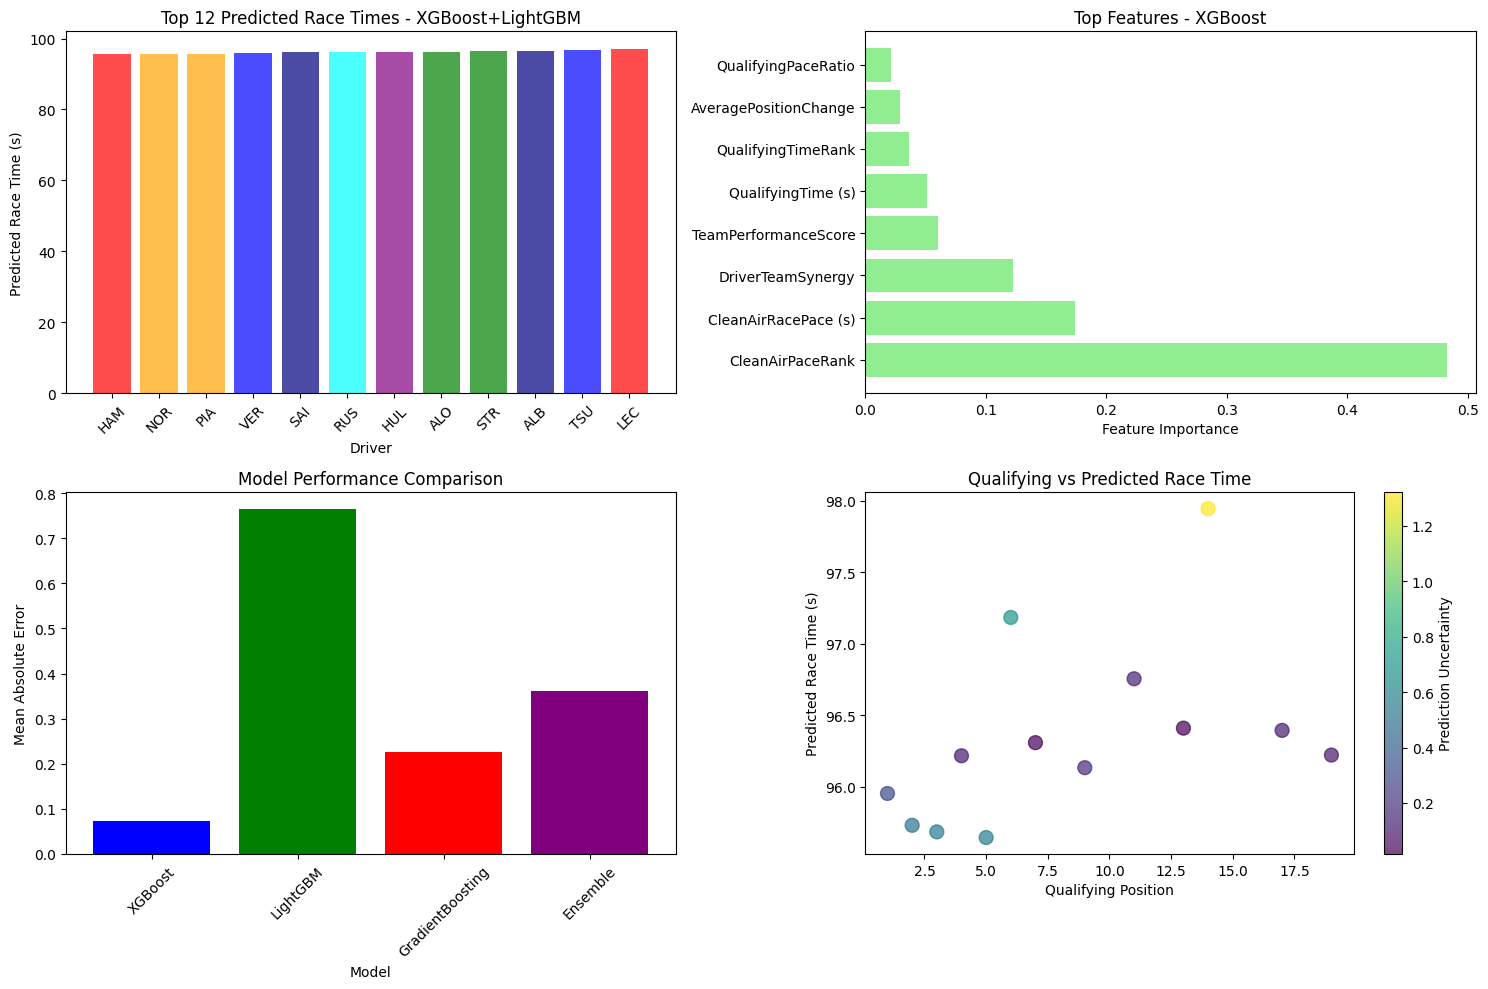


✨ Ensemble Model Summary:
   • Combined XGBoost (40%) + LightGBM (40%) + GradientBoosting (20%)
   • 18 advanced features including pace ratios and team synergy
   • Cross-validation MAE: 1.195 seconds
   • Most important factor: CleanAirPaceRank


In [8]:
print("\n🏁 XGBoost + LightGBM Ensemble Prediction - British GP 2025 🏁")
print("=" * 65)
print(f"Weather: {rain_probability*100:.1f}% rain chance, {temperature}°C")
print("=" * 65)

# Show top 15 with gaps
for idx, row in final_results.head(15).iterrows():
    gap = row["PredictedRaceTime (s)"] - final_results.iloc[0]["PredictedRaceTime (s)"]
    print(f"P{idx+1:2d}: {row['Driver']} ({row['Team']}) - {row['PredictedRaceTime (s)']:.3f}s (+{gap:.3f})")

print("\n🏆 PREDICTED PODIUM 🏆")
podium = final_results.head(3)
for i, (idx, row) in enumerate(podium.iterrows()):
    medals = ["🥇", "🥈", "🥉"]
    print(f"{medals[i]} P{i+1}: {row['Driver']} ({row['Team']}) - {row['PredictedRaceTime (s)']:.3f}s")

# Special mentions and comparisons
hamilton_pos = final_results[final_results["Driver"] == "HAM"].index[0] + 1
hulkenberg_pos = final_results[final_results["Driver"] == "HUL"].index[0] + 1
piastri_pos = final_results[final_results["Driver"] == "PIA"].index[0] + 1

print(f"\n🎯 Key Driver Predictions:")
print(f"🇬🇧 Hamilton (Ferrari): P{hamilton_pos}")
print(f"🏎️  Piastri (McLaren): P{piastri_pos}")
print(f"🎉 Hulkenberg (Kick Sauber): P{hulkenberg_pos}")

# Feature importance from XGBoost
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(f"\n📊 Top 5 Most Important Features (XGBoost):")
for i, row in importance_df.head().iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.3f}")

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Predicted times
plt.subplot(2, 2, 1)
drivers = final_results['Driver'][:12]
times = final_results['PredictedRaceTime (s)'][:12]
teams = final_results['Team'][:12]

colors = {'McLaren': 'orange', 'Red Bull': 'blue', 'Ferrari': 'red', 
          'Mercedes': 'cyan', 'Aston Martin': 'green', 'Williams': 'navy',
          'Haas': 'gray', 'Alpine': 'pink', 'Racing Bulls': 'lightblue',
          'Kick Sauber': 'purple'}

bar_colors = [colors.get(team, 'black') for team in teams]
plt.bar(drivers, times, color=bar_colors, alpha=0.7)
plt.xlabel('Driver')
plt.ylabel('Predicted Race Time (s)')
plt.title('Top 12 Predicted Race Times - XGBoost+LightGBM')
plt.xticks(rotation=45)

# Plot 2: Feature importance
plt.subplot(2, 2, 2)
top_features = importance_df.head(8)
plt.barh(top_features['Feature'], top_features['Importance'], color='lightgreen')
plt.xlabel('Feature Importance')
plt.title('Top Features - XGBoost')

# Plot 3: Model comparison
plt.subplot(2, 2, 3)
model_names = ['XGBoost', 'LightGBM', 'GradientBoosting', 'Ensemble']
model_maes = [mean_absolute_error(y, model_predictions[name]) for name in model_names]
plt.bar(model_names, model_maes, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)

# Plot 4: Prediction uncertainty
plt.subplot(2, 2, 4)
plt.scatter(final_results['QualifyingPosition'][:15], 
           final_results['PredictedRaceTime (s)'][:15], 
           c=final_results['PredictionUncertainty'][:15], 
           cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Prediction Uncertainty')
plt.xlabel('Qualifying Position')
plt.ylabel('Predicted Race Time (s)')
plt.title('Qualifying vs Predicted Race Time')

plt.tight_layout()
plt.show()

print(f"\n✨ Ensemble Model Summary:")
print(f"   • Combined XGBoost (40%) + LightGBM (40%) + GradientBoosting (20%)")
print(f"   • {len(feature_columns)} advanced features including pace ratios and team synergy")
print(f"   • Cross-validation MAE: {-cv_scores.mean():.3f} seconds")
print(f"   • Most important factor: {importance_df.iloc[0]['Feature']}")